# Accident Detection System

## 1. Introduction

dataset in use https://www.kaggle.com/datasets/fahaddalwai/cctvfootagevideo/data for this demo

## 2. Importing libraries

In [ ]:
!pip install tensorflow

In [ ]:
!pip install numpy==1.24.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 37.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albucore 0.0.19 requires numpy>=1.24.4, but you have numpy 1.24.3 which is incompatible.
albumentations 1.4.20 requires numpy>=1.24.4, but you have numpy 1.24.3 which is incompatible.


In [1]:
from google.colab import drive

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)


In [ ]:
# Set TensorFlow GPU memory growth and limits
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        for device in physical_devices:
            # Enable memory growth instead of pre-allocating all memory
            tf.config.experimental.set_memory_growth(device, True)
    except RuntimeError as e:
        print(f"Error setting memory growth: {e}")

    try:
        # Restrict GPU RAM usage to 6GB
        tf.config.experimental.set_virtual_device_configuration(
            physical_devices[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10240)]
        )
    except RuntimeError as e:
        print(f"Error setting virtual memory configuration: {e}")

In [4]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# frame extraction

def extract_frames(video_path, frames_dir, skip_frames=1):
    """
    Extract frames from a video and save them as images.

    Parameters:
    - video_path: Path to the video file.
    - frames_dir: Directory to save extracted frames.
    - skip_frames: Extract every nth frame to reduce data size.
    """
    os.makedirs(frames_dir, exist_ok=True)
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    saved_count = 0

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print(f"Total frames in video: {total_frames}")

    for _ in tqdm(range(total_frames), desc="Extracting frames"):
        ret, frame = cap.read()
        if not ret:
            break
        if frame_count % skip_frames == 0:
            frame_path = os.path.join(frames_dir, f"frame_{frame_count:05d}.jpg")
            cv2.imwrite(frame_path, frame)
            saved_count += 1
        frame_count += 1

    cap.release()
    print(f"Extracted and saved {saved_count} frames.")

# Parameters (Update for Google Drive paths)
video_path = '/content/drive/My Drive/accident_detection_mvp/data/raw_video.mp4'
frames_dir = '/content/drive/My Drive/accident_detection_mvp/data_new/frames/'
skip_frames = 5  # Extract every 5th frame to reduce data size

# Extract frames
extract_frames(video_path, frames_dir, skip_frames)

Total frames in video: 2298


Extracting frames: 100%|██████████| 2298/2298 [00:07<00:00, 321.23it/s]

Extracted and saved 460 frames.


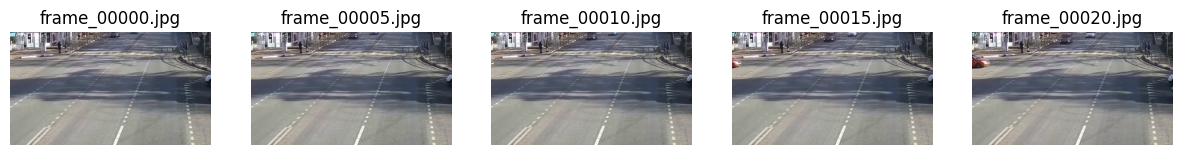

In [ ]:
## annotation

# Initialize an empty DataFrame for annotations
annotations = pd.DataFrame(columns=['frame_number', 'label'])

# List all frame files
frame_files = sorted([f for f in os.listdir(frames_dir) if f.endswith('.jpg')])

# Display sample frames for manual labeling
num_samples = 5
plt.figure(figsize=(15, 5))
for i in range(num_samples):
    plt.subplot(1, num_samples, i+1)
    img = cv2.imread(os.path.join(frames_dir, frame_files[i]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title(f"{frame_files[i]}")
    plt.axis('off')
plt.show()


In [ ]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint
import os

# 1. Define Paths and Parameters
train_dir = '/content/drive/My Drive/accident_detection_mvp/data/train'
val_dir = '/content/drive/My Drive/accident_detection_mvp/data/val'
test_dir = '/content/drive/My Drive/accident_detection_mvp/data/test'

img_height = 250
img_width = 250
batch_size = 100

In [6]:
# 2. Load Datasets with `image_dataset_from_directory`
# This approach automatically handles batching and shuffling

training_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb'
)

validation_data = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb'
)

testing_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb'
)

# Save class names before applying performance optimizations
class_names = training_data.class_names

Found 9266 files belonging to 2 classes.
Found 1893 files belonging to 2 classes.
Found 971 files belonging to 2 classes.


In [7]:
# # 3. Configure Dataset for Performance
# AUTOTUNE = tf.data.experimental.AUTOTUNE
# training_data = training_data.cache().prefetch(buffer_size=AUTOTUNE)
# validation_data = validation_data.cache().prefetch(buffer_size=AUTOTUNE)
# testing_data = testing_data.cache().prefetch(buffer_size=AUTOTUNE)


# Configure Dataset for Performance with Disk Caching
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Cache the training dataset to disk
training_data = training_data.cache('/tmp/training_cache').prefetch(buffer_size=AUTOTUNE)

# Cache validation and testing datasets to disk (optional)
validation_data = validation_data.cache('/tmp/validation_cache').prefetch(buffer_size=AUTOTUNE)
testing_data = testing_data.cache('/tmp/testing_cache').prefetch(buffer_size=AUTOTUNE)


In [8]:
# 4. Define the CNN Model
model = models.Sequential([
    layers.Rescaling(1./255),
    layers.BatchNormalization(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(256, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dense(2, activation='softmax')
])


# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Epoch 1/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 296s 3s/step - accuracy: 0.6018 - loss: 1.0772 - val_accuracy: 0.7353 - val_loss: 0.6175
Epoch 2/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 21s 226ms/step - accuracy: 0.7544 - loss: 0.4923 - val_accuracy: 0.8204 - val_loss: 0.4700
Epoch 3/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 21s 228ms/step - accuracy: 0.8164 - loss: 0.3936 - val_accuracy: 0.8521 - val_loss: 0.3428
Epoch 4/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 21s 224ms/step - accuracy: 0.8605 - loss: 0.3179 - val_accuracy: 0.8986 - val_loss: 0.2546
Epoch 5/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 21s 222ms/step - accuracy: 0.8872 - loss: 0.2634 - val_accuracy: 0.9007 - val_loss: 0.2383
Epoch 6/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 21s 225ms/step - accuracy: 0.9080 - loss: 0.2175 - val_accuracy: 0.9171 - val_loss: 0.2236
Epoch 7/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 21s 226ms/step - accuracy: 0.9261 - loss: 0.1814 - val_accuracy: 0.9208 - val_loss: 0.2213
Epoch 8/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 21s 224ms/step - accuracy: 0.9373 - loss: 0.1560 - val_accura

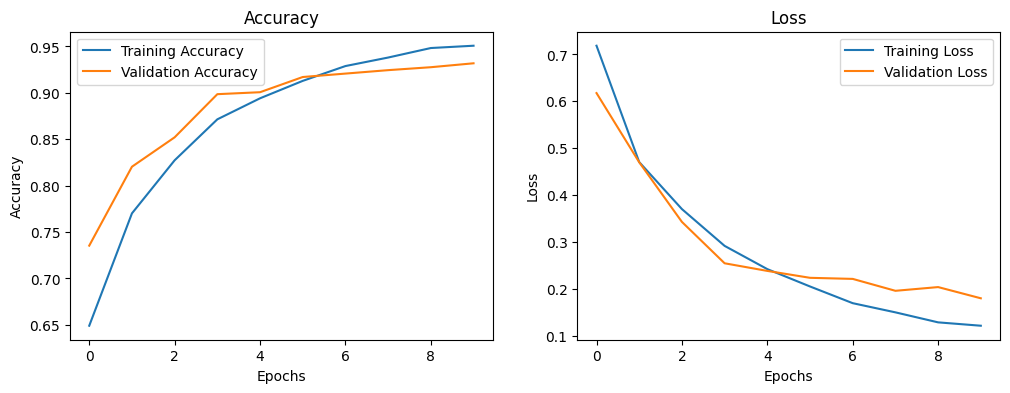

In [9]:
# 7. Plot Training and Validation Metrics

history = model.fit(training_data, validation_data=validation_data, epochs=10)

plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [10]:
# 8. Evaluate on Testing Data
test_loss, test_accuracy = model.evaluate(testing_data)
print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test Loss: {test_loss:.2f}")

# 9. Visualize Predictions on Testing Data
plt.figure(figsize=(20, 20))
for images, labels in testing_data.take(1):
    predictions = model.predict(images)
    pred_labels = [class_names[np.argmax(pred)] for pred in predictions]
    true_labels = [class_names[label] for label in labels]

    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Pred: {pred_labels[i]} | True: {true_labels[i]}")
        plt.axis("off")

plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [11]:
test_loss, test_accuracy = model.evaluate(testing_data)
print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test Loss: {test_loss:.2f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.9433 - loss: 0.1754
Test Accuracy: 0.94
Test Loss: 0.18


In [12]:
# Save the trained model
model.save("/content/drive/My Drive/accident_detection_mvp/accident_detection_model.keras")

In [ ]:
predictions

array([[0.99164295, 0.00835702],
       [0.9836662 , 0.01633381],
       [0.98309934, 0.01690069],
       [0.9571307 , 0.04286937],
       [0.99637294, 0.00362714],
       [0.84433496, 0.15566508],
       [0.6286282 , 0.37137178],
       [0.00247444, 0.9975255 ],
       [0.9963486 , 0.00365129],
       [0.9754117 , 0.0245883 ],
       [0.993422  , 0.00657806],
       [0.79846835, 0.20153159],
       [0.840631  , 0.15936905],
       [0.99370086, 0.00629914],
       [0.9921361 , 0.00786389],
       [0.9438491 , 0.05615088],
       [0.9837277 , 0.01627225],
       [0.9974712 , 0.00252875],
       [0.00493225, 0.9950677 ],
       [0.9676248 , 0.03237528],
       [0.968664  , 0.03133595],
       [0.8670464 , 0.13295357],
       [0.00737222, 0.9926278 ],
       [0.99809605, 0.00190393],
       [0.92873156, 0.07126848],
       [0.9895139 , 0.01048608],
       [0.98941606, 0.01058387],
       [0.6217631 , 0.37823686],
       [0.9897121 , 0.01028792]], dtype=float32)

In [ ]:
# 9. Visualize Predictions on Testing Data
print(testing_data.take(1))
for images, labels in testing_data.take(1):
    predictions = model.predict(images)
    print(predictions)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
[[0.99164295 0.00835702]
 [0.9836662  0.01633381]
 [0.98309934 0.01690069]
 [0.9571307  0.04286937]
 [0.99637294 0.00362714]
 [0.84433496 0.15566508]
 [0.6286282  0.37137178]
 [0.00247444 0.9975255 ]
 [0.9963486  0.00365129]
 [0.9754117  0.0245883 ]
 [0.993422   0.00657806]
 [0.79846835 0.20153159]
 [0.840631   0.15936905]
 [0.99370086 0.00629914]
 [0.9921361  0.00786389]
 [0.9438491  0.05615088]
 [0.9837277  0.01627225]
 [0.9974712  0.00252875]
 [0.00493225 0.9950677 ]
 [0.9676248  0.03237528]
 [0.968664   0.03133595]
 [0.8670464  0.13295357]
 [0.00737222 0.9926278 ]
 [0.99809605 0.00190393]
 [0.92873156 0.07126848]
 [0.9895139  0.01048608]
 [0.98941606 0.01058387]
 [0.6217631  0.37823686]
 [0.9897121  0.01028792]]


## GENERATING ANNOTATIONS

In [ ]:
# frame extraction

def extract_frames(video_path, frames_dir, skip_frames=1):
    """
    Extract frames from a video and save them as images.

    Parameters:
    - video_path: Path to the video file.
    - frames_dir: Directory to save extracted frames.
    - skip_frames: Extract every nth frame to reduce data size.
    """
    os.makedirs(frames_dir, exist_ok=True)
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    saved_count = 0

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print(f"Total frames in video: {total_frames}")

    for _ in tqdm(range(total_frames), desc="Extracting frames"):
        ret, frame = cap.read()
        if not ret:
            break
        if frame_count % skip_frames == 0:
            frame_path = os.path.join(frames_dir, f"frame_{frame_count:05d}.jpg")
            cv2.imwrite(frame_path, frame)
            saved_count += 1
        frame_count += 1

    cap.release()
    print(f"Extracted and saved {saved_count} frames.")

# Parameters (Update for Google Drive paths)
video_path = '/content/drive/My Drive/accident_detection_mvp/data_new/videos/pedest.mp4'
frames_dir = '/content/drive/My Drive/accident_detection_mvp/data_new/frames/'
skip_frames = 5  # Extract every 5th frame to reduce data size

# Extract frames
extract_frames(video_path, frames_dir, skip_frames)

Total frames in video: 5311


Extracting frames:  72%|███████▏  | 3833/5311 [00:14<00:05, 263.16it/s]

Extracted and saved 767 frames.


In [ ]:
frames_dir = '/content/drive/My Drive/accident_detection_mvp/data_new/frames/'  # Directory containing the frames extracted from the video
accident_frames_dir = '/content/drive/My Drive/accident_detection_mvp/data_new/predicted_01/Accident/'
non_accident_frames_dir = '/content/drive/My Drive/accident_detection_mvp/data_new/predicted_01/No Accident/'


os.makedirs(accident_frames_dir, exist_ok=True)
os.makedirs(non_accident_frames_dir, exist_ok=True)


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
import shutil
from tqdm import tqdm

# Load the best model
from tensorflow.keras.models import load_model
model = load_model("/content/drive/My Drive/accident_detection_mvp/accident_detection_model.keras")

In [ ]:
# Create a static copy of frame file names
frame_files = sorted([f for f in os.listdir(frames_dir) if f.endswith('.jpg')])
frame_files_copy = frame_files.copy()  # Create a copy to avoid issues during iteration

# Classify frames
for frame_file in tqdm(frame_files_copy, desc="Classifying frames"):
    img_path = os.path.join(frames_dir, frame_file)
    print(img_path)

    # Load and preprocess image
    img = image.load_img(img_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Predict
    prediction = model.predict(img_array)[0]  # Get the probabilities for both classes

    # print("Prediction", prediction)

    # Get the predicted class index
    predicted_class = np.argmax(prediction)  # Returns 0 or 1

    # Map predicted class to label and destination directory
    if predicted_class > 0.5:
        label = 'No Accident'
        dest_dir = accident_frames_dir
    else:
        label = 'Accident'
        dest_dir = non_accident_frames_dir

    # Move the frame to the corresponding folder
    shutil.move(img_path, os.path.join(dest_dir, frame_file))


Classifying frames:   0%|          | 0/767 [00:00<?, ?it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00000.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Classifying frames:   0%|          | 1/767 [00:02<31:37,  2.48s/it]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00005.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00010.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Classifying frames:   0%|          | 3/767 [00:02<08:49,  1.44it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00015.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00020.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying frames:   1%|          | 5/767 [00:02<04:46,  2.66it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00025.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00030.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Classifying frames:   1%|          | 7/767 [00:02<03:05,  4.09it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00035.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00040.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying frames:   1%|          | 9/767 [00:06<10:12,  1.24it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00045.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00050.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying frames:   1%|▏         | 11/767 [00:06<06:54,  1.83it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00055.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00060.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Classifying frames:   2%|▏         | 13/767 [00:06<04:53,  2.57it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00065.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00070.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying frames:   2%|▏         | 15/767 [00:06<03:34,  3.50it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00075.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00080.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Classifying frames:   2%|▏         | 17/767 [00:06<02:41,  4.63it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00085.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00090.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Classifying frames:   2%|▏         | 19/767 [00:07<02:06,  5.92it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00095.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00100.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Classifying frames:   3%|▎         | 21/767 [00:07<01:45,  7.06it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00105.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00110.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying frames:   3%|▎         | 23/767 [00:07<01:35,  7.81it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00115.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00120.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Classifying frames:   3%|▎         | 25/767 [00:07<01:22,  8.98it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00125.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00130.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Classifying frames:   4%|▎         | 27/767 [00:07<01:13, 10.09it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00135.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00140.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Classifying frames:   4%|▍         | 29/767 [00:07<01:05, 11.23it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00145.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00150.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Classifying frames:   4%|▍         | 31/767 [00:07<00:59, 12.27it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00155.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00160.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Classifying frames:   4%|▍         | 33/767 [00:08<00:55, 13.18it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00165.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00170.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Classifying frames:   5%|▍         | 35/767 [00:08<00:57, 12.64it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00175.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00180.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Classifying frames:   5%|▍         | 37/767 [00:08<00:57, 12.76it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00185.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00190.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying frames:   5%|▌         | 39/767 [00:08<00:54, 13.24it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00195.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00200.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Classifying frames:   5%|▌         | 41/767 [00:08<00:52, 13.83it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00205.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00210.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Classifying frames:   6%|▌         | 43/767 [00:08<00:51, 14.10it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00215.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00220.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Classifying frames:   6%|▌         | 45/767 [00:08<00:50, 14.20it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00225.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00230.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying frames:   6%|▌         | 47/767 [00:09<00:50, 14.29it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00235.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00240.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Classifying frames:   6%|▋         | 49/767 [00:09<00:55, 12.93it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00245.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00250.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Classifying frames:   7%|▋         | 51/767 [00:09<00:55, 12.92it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00255.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00260.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Classifying frames:   7%|▋         | 53/767 [00:09<01:00, 11.76it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00265.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00270.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Classifying frames:   7%|▋         | 55/767 [00:09<01:03, 11.27it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00275.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00280.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Classifying frames:   7%|▋         | 57/767 [00:10<01:04, 11.08it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00285.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00290.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Classifying frames:   8%|▊         | 59/767 [00:10<01:05, 10.74it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00295.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00300.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Classifying frames:   8%|▊         | 61/767 [00:10<01:09, 10.22it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00305.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00310.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Classifying frames:   8%|▊         | 63/767 [00:10<01:08, 10.32it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00315.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00320.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Classifying frames:   8%|▊         | 65/767 [00:10<01:10,  9.96it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00325.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00330.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Classifying frames:   9%|▊         | 67/767 [00:11<01:09, 10.04it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00335.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00340.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Classifying frames:   9%|▉         | 69/767 [00:11<01:10,  9.92it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00345.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Classifying frames:   9%|▉         | 70/767 [00:11<01:10,  9.89it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00350.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Classifying frames:   9%|▉         | 71/767 [00:11<01:12,  9.58it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00355.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Classifying frames:   9%|▉         | 72/767 [00:11<01:12,  9.62it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00360.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00365.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Classifying frames:  10%|▉         | 74/767 [00:11<01:09, 10.01it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00370.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00375.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Classifying frames:  10%|▉         | 76/767 [00:11<01:08, 10.07it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00380.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00385.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Classifying frames:  10%|█         | 78/767 [00:12<01:08, 10.05it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00390.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00395.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Classifying frames:  10%|█         | 80/767 [00:12<01:13,  9.30it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00400.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Classifying frames:  11%|█         | 81/767 [00:12<01:16,  8.98it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00405.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00410.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Classifying frames:  11%|█         | 83/767 [00:12<01:15,  9.09it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00415.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Classifying frames:  11%|█         | 84/767 [00:12<01:15,  9.02it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00420.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Classifying frames:  11%|█         | 85/767 [00:12<01:14,  9.15it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00425.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Classifying frames:  11%|█         | 86/767 [00:13<01:13,  9.22it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00430.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Classifying frames:  11%|█▏        | 87/767 [00:13<01:24,  8.09it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00435.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Classifying frames:  11%|█▏        | 88/767 [00:13<01:23,  8.15it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00440.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00445.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Classifying frames:  12%|█▏        | 90/767 [00:13<01:14,  9.04it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00450.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Classifying frames:  12%|█▏        | 91/767 [00:13<01:13,  9.20it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00455.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00460.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Classifying frames:  12%|█▏        | 93/767 [00:13<01:09,  9.66it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00465.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Classifying frames:  12%|█▏        | 94/767 [00:13<01:11,  9.46it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00470.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Classifying frames:  12%|█▏        | 95/767 [00:14<01:11,  9.46it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00475.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Classifying frames:  13%|█▎        | 96/767 [00:14<01:10,  9.47it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00480.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Classifying frames:  13%|█▎        | 97/767 [00:14<01:12,  9.21it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00485.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Classifying frames:  13%|█▎        | 98/767 [00:14<01:16,  8.74it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00490.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00495.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Classifying frames:  13%|█▎        | 100/767 [00:14<01:02, 10.67it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00500.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00505.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying frames:  13%|█▎        | 102/767 [00:14<00:57, 11.50it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00510.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00515.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying frames:  14%|█▎        | 104/767 [00:14<00:54, 12.16it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00520.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00525.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Classifying frames:  14%|█▍        | 106/767 [00:14<00:51, 12.76it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00530.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00535.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Classifying frames:  14%|█▍        | 108/767 [00:15<00:48, 13.49it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00540.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00545.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Classifying frames:  14%|█▍        | 110/767 [00:15<00:51, 12.66it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00550.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00555.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Classifying frames:  15%|█▍        | 112/767 [00:15<00:51, 12.68it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00560.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00565.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying frames:  15%|█▍        | 114/767 [00:15<00:49, 13.28it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00570.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00575.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying frames:  15%|█▌        | 116/767 [00:15<00:48, 13.40it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00580.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00585.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Classifying frames:  15%|█▌        | 118/767 [00:15<00:47, 13.75it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00590.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00595.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Classifying frames:  16%|█▌        | 120/767 [00:15<00:46, 13.98it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00600.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00605.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Classifying frames:  16%|█▌        | 122/767 [00:16<00:45, 14.02it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00610.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00615.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Classifying frames:  16%|█▌        | 124/767 [00:16<00:48, 13.15it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00620.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00625.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Classifying frames:  16%|█▋        | 126/767 [00:16<00:48, 13.18it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00630.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00635.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Classifying frames:  17%|█▋        | 128/767 [00:16<00:47, 13.47it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00640.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00645.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying frames:  17%|█▋        | 130/767 [00:16<00:48, 13.18it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00650.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00655.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying frames:  17%|█▋        | 132/767 [00:16<00:47, 13.32it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00660.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00665.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying frames:  17%|█▋        | 134/767 [00:17<00:46, 13.73it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00670.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00675.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Classifying frames:  18%|█▊        | 136/767 [00:17<00:47, 13.38it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00680.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00685.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying frames:  18%|█▊        | 138/767 [00:17<00:48, 12.88it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00690.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00695.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Classifying frames:  18%|█▊        | 140/767 [00:17<00:46, 13.35it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00700.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00705.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying frames:  19%|█▊        | 142/767 [00:17<00:46, 13.48it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00710.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00715.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Classifying frames:  19%|█▉        | 144/767 [00:17<00:47, 13.15it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00720.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00725.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Classifying frames:  19%|█▉        | 146/767 [00:17<00:46, 13.42it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00730.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00735.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Classifying frames:  19%|█▉        | 148/767 [00:18<00:45, 13.47it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00740.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00745.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Classifying frames:  20%|█▉        | 150/767 [00:18<00:47, 13.06it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00750.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00755.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying frames:  20%|█▉        | 152/767 [00:18<00:46, 13.10it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00760.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00765.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying frames:  20%|██        | 154/767 [00:18<00:45, 13.39it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00770.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00775.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Classifying frames:  20%|██        | 156/767 [00:18<00:47, 12.77it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00780.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00785.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying frames:  21%|██        | 158/767 [00:18<00:46, 13.02it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00790.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00795.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying frames:  21%|██        | 160/767 [00:19<00:45, 13.43it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00800.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00805.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Classifying frames:  21%|██        | 162/767 [00:19<00:45, 13.22it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00810.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00815.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Classifying frames:  21%|██▏       | 164/767 [00:19<00:47, 12.65it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00820.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00825.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Classifying frames:  22%|██▏       | 166/767 [00:19<00:45, 13.16it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00830.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00835.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Classifying frames:  22%|██▏       | 168/767 [00:19<00:44, 13.56it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00840.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00845.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Classifying frames:  22%|██▏       | 170/767 [00:19<00:43, 13.58it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00850.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00855.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Classifying frames:  22%|██▏       | 172/767 [00:19<00:44, 13.41it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00860.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00865.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Classifying frames:  23%|██▎       | 174/767 [00:20<00:43, 13.55it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00870.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00875.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Classifying frames:  23%|██▎       | 176/767 [00:20<00:43, 13.57it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00880.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00885.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Classifying frames:  23%|██▎       | 178/767 [00:20<00:44, 13.12it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00890.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00895.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying frames:  23%|██▎       | 180/767 [00:20<00:43, 13.56it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00900.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00905.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Classifying frames:  24%|██▎       | 182/767 [00:20<00:44, 13.17it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00910.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00915.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Classifying frames:  24%|██▍       | 184/767 [00:20<00:44, 13.22it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00920.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00925.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Classifying frames:  24%|██▍       | 186/767 [00:20<00:44, 13.14it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00930.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00935.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Classifying frames:  25%|██▍       | 188/767 [00:21<00:42, 13.71it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00940.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00945.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Classifying frames:  25%|██▍       | 190/767 [00:21<00:44, 12.97it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00950.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00955.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Classifying frames:  25%|██▌       | 192/767 [00:21<00:44, 12.87it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00960.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00965.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Classifying frames:  25%|██▌       | 194/767 [00:21<00:43, 13.23it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00970.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00975.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying frames:  26%|██▌       | 196/767 [00:21<00:42, 13.48it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00980.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00985.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Classifying frames:  26%|██▌       | 198/767 [00:21<00:42, 13.31it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00990.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_00995.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Classifying frames:  26%|██▌       | 200/767 [00:22<00:41, 13.67it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01000.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01005.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Classifying frames:  26%|██▋       | 202/767 [00:22<00:41, 13.61it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01010.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01015.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Classifying frames:  27%|██▋       | 204/767 [00:22<00:44, 12.66it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01020.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01025.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying frames:  27%|██▋       | 206/767 [00:22<00:45, 12.44it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01030.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01035.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Classifying frames:  27%|██▋       | 208/767 [00:22<00:43, 12.78it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01040.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01045.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Classifying frames:  27%|██▋       | 210/767 [00:22<00:41, 13.46it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01050.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01055.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying frames:  28%|██▊       | 212/767 [00:22<00:42, 13.05it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01060.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01065.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying frames:  28%|██▊       | 214/767 [00:23<00:41, 13.46it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01070.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01075.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Classifying frames:  28%|██▊       | 216/767 [00:23<00:43, 12.57it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01080.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01085.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Classifying frames:  28%|██▊       | 218/767 [00:23<00:44, 12.34it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01090.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01095.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Classifying frames:  29%|██▊       | 220/767 [00:23<00:43, 12.68it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01100.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01105.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Classifying frames:  29%|██▉       | 222/767 [00:23<00:42, 12.90it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01110.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01115.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying frames:  29%|██▉       | 224/767 [00:23<00:42, 12.90it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01120.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01125.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Classifying frames:  29%|██▉       | 226/767 [00:24<00:40, 13.23it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01130.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01135.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Classifying frames:  30%|██▉       | 228/767 [00:24<00:43, 12.43it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01140.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01145.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying frames:  30%|██▉       | 230/767 [00:24<00:43, 12.39it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01150.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01155.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Classifying frames:  30%|███       | 232/767 [00:24<00:47, 11.21it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01160.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01165.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Classifying frames:  31%|███       | 234/767 [00:24<00:48, 10.92it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01170.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01175.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Classifying frames:  31%|███       | 236/767 [00:25<00:51, 10.32it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01180.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01185.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Classifying frames:  31%|███       | 238/767 [00:25<00:53,  9.89it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01190.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01195.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Classifying frames:  31%|███▏      | 240/767 [00:25<00:54,  9.62it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01200.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01205.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Classifying frames:  32%|███▏      | 242/767 [00:25<00:53,  9.73it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01210.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01215.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Classifying frames:  32%|███▏      | 244/767 [00:25<00:53,  9.83it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01220.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01225.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Classifying frames:  32%|███▏      | 246/767 [00:26<00:53,  9.81it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01230.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Classifying frames:  32%|███▏      | 247/767 [00:26<00:53,  9.75it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01235.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Classifying frames:  32%|███▏      | 248/767 [00:26<00:55,  9.28it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01240.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01245.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Classifying frames:  33%|███▎      | 250/767 [00:26<00:53,  9.70it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01250.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Classifying frames:  33%|███▎      | 251/767 [00:26<00:53,  9.69it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01255.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Classifying frames:  33%|███▎      | 252/767 [00:26<00:54,  9.40it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01260.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01265.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Classifying frames:  33%|███▎      | 254/767 [00:26<00:52,  9.69it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01270.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01275.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Classifying frames:  33%|███▎      | 256/767 [00:27<00:53,  9.57it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01280.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Classifying frames:  34%|███▎      | 257/767 [00:27<00:56,  9.02it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01285.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Classifying frames:  34%|███▎      | 258/767 [00:27<00:58,  8.72it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01290.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Classifying frames:  34%|███▍      | 259/767 [00:27<00:57,  8.76it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01295.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Classifying frames:  34%|███▍      | 260/767 [00:27<00:57,  8.89it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01300.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Classifying frames:  34%|███▍      | 261/767 [00:27<00:56,  9.01it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01305.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Classifying frames:  34%|███▍      | 262/767 [00:27<00:55,  9.16it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01310.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Classifying frames:  34%|███▍      | 263/767 [00:27<00:58,  8.69it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01315.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Classifying frames:  34%|███▍      | 264/767 [00:28<00:57,  8.72it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01320.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Classifying frames:  35%|███▍      | 265/767 [00:28<00:57,  8.67it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01325.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Classifying frames:  35%|███▍      | 266/767 [00:28<00:59,  8.39it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01330.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Classifying frames:  35%|███▍      | 267/767 [00:28<00:57,  8.64it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01335.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01340.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Classifying frames:  35%|███▌      | 269/767 [00:28<00:53,  9.24it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01345.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Classifying frames:  35%|███▌      | 270/767 [00:28<00:53,  9.23it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01350.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01355.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Classifying frames:  35%|███▌      | 272/767 [00:28<00:53,  9.25it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01360.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01365.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Classifying frames:  36%|███▌      | 274/767 [00:29<00:52,  9.31it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01370.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Classifying frames:  36%|███▌      | 275/767 [00:29<00:57,  8.59it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01375.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Classifying frames:  36%|███▌      | 276/767 [00:29<00:57,  8.58it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01380.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01385.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Classifying frames:  36%|███▌      | 278/767 [00:29<00:49,  9.89it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01390.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01395.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Classifying frames:  37%|███▋      | 280/767 [00:29<00:44, 11.03it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01400.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01405.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Classifying frames:  37%|███▋      | 282/767 [00:29<00:40, 12.00it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01410.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01415.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Classifying frames:  37%|███▋      | 284/767 [00:30<00:39, 12.19it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01420.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01425.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Classifying frames:  37%|███▋      | 286/767 [00:30<00:38, 12.50it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01430.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01435.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Classifying frames:  38%|███▊      | 288/767 [00:30<00:41, 11.54it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01440.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01445.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying frames:  38%|███▊      | 290/767 [00:30<00:39, 12.12it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01450.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01455.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Classifying frames:  38%|███▊      | 292/767 [00:30<00:37, 12.54it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01460.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01465.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying frames:  38%|███▊      | 294/767 [00:30<00:36, 12.94it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01470.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01475.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying frames:  39%|███▊      | 296/767 [00:30<00:35, 13.21it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01480.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01485.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Classifying frames:  39%|███▉      | 298/767 [00:31<00:35, 13.14it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01490.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01495.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Classifying frames:  39%|███▉      | 300/767 [00:31<00:37, 12.43it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01500.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01505.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying frames:  39%|███▉      | 302/767 [00:31<00:37, 12.46it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01510.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01515.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Classifying frames:  40%|███▉      | 304/767 [00:31<00:35, 12.92it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01520.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01525.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Classifying frames:  40%|███▉      | 306/767 [00:31<00:34, 13.28it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01530.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01535.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying frames:  40%|████      | 308/767 [00:31<00:33, 13.54it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01540.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01545.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Classifying frames:  40%|████      | 310/767 [00:32<00:33, 13.54it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01550.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01555.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Classifying frames:  41%|████      | 312/767 [00:32<00:34, 13.19it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01560.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01565.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Classifying frames:  41%|████      | 314/767 [00:32<00:36, 12.37it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01570.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01575.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Classifying frames:  41%|████      | 316/767 [00:32<00:35, 12.73it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01580.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01585.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Classifying frames:  41%|████▏     | 318/767 [00:32<00:34, 13.18it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01590.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01595.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Classifying frames:  42%|████▏     | 320/767 [00:32<00:33, 13.31it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01600.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01605.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Classifying frames:  42%|████▏     | 322/767 [00:32<00:35, 12.62it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01610.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01615.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying frames:  42%|████▏     | 324/767 [00:33<00:34, 12.95it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01620.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01625.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Classifying frames:  43%|████▎     | 326/767 [00:33<00:36, 12.16it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01630.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01635.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Classifying frames:  43%|████▎     | 328/767 [00:33<00:36, 12.08it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01640.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01645.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Classifying frames:  43%|████▎     | 330/767 [00:33<00:34, 12.64it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01650.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01655.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Classifying frames:  43%|████▎     | 332/767 [00:33<00:33, 12.90it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01660.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01665.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying frames:  44%|████▎     | 334/767 [00:33<00:32, 13.21it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01670.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01675.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Classifying frames:  44%|████▍     | 336/767 [00:34<00:32, 13.11it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01680.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01685.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Classifying frames:  44%|████▍     | 338/767 [00:34<00:33, 12.82it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01690.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01695.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Classifying frames:  44%|████▍     | 340/767 [00:34<00:35, 12.16it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01700.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01705.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Classifying frames:  45%|████▍     | 342/767 [00:34<00:34, 12.34it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01710.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01715.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Classifying frames:  45%|████▍     | 344/767 [00:34<00:34, 12.23it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01720.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01725.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying frames:  45%|████▌     | 346/767 [00:34<00:33, 12.49it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01730.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01735.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Classifying frames:  45%|████▌     | 348/767 [00:35<00:33, 12.48it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01740.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01745.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Classifying frames:  46%|████▌     | 350/767 [00:35<00:33, 12.28it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01750.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01755.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Classifying frames:  46%|████▌     | 352/767 [00:35<00:35, 11.73it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01760.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01765.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying frames:  46%|████▌     | 354/767 [00:35<00:34, 11.83it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01770.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01775.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Classifying frames:  46%|████▋     | 356/767 [00:35<00:32, 12.48it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01780.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01785.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Classifying frames:  47%|████▋     | 358/767 [00:35<00:31, 12.92it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01790.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01795.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Classifying frames:  47%|████▋     | 360/767 [00:35<00:31, 13.11it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01800.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01805.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Classifying frames:  47%|████▋     | 362/767 [00:36<00:31, 12.92it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01810.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01815.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Classifying frames:  47%|████▋     | 364/767 [00:36<00:32, 12.38it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01820.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01825.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Classifying frames:  48%|████▊     | 366/767 [00:36<00:33, 12.15it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01830.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01835.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Classifying frames:  48%|████▊     | 368/767 [00:36<00:31, 12.66it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01840.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01845.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying frames:  48%|████▊     | 370/767 [00:36<00:30, 13.09it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01850.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01855.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Classifying frames:  49%|████▊     | 372/767 [00:36<00:29, 13.29it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01860.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01865.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Classifying frames:  49%|████▉     | 374/767 [00:37<00:28, 13.56it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01870.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01875.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Classifying frames:  49%|████▉     | 376/767 [00:37<00:30, 12.72it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01880.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01885.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Classifying frames:  49%|████▉     | 378/767 [00:37<00:31, 12.34it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01890.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01895.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying frames:  50%|████▉     | 380/767 [00:37<00:31, 12.45it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01900.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01905.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying frames:  50%|████▉     | 382/767 [00:37<00:29, 12.93it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01910.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01915.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Classifying frames:  50%|█████     | 384/767 [00:37<00:29, 12.95it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01920.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01925.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Classifying frames:  50%|█████     | 386/767 [00:38<00:28, 13.18it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01930.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01935.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Classifying frames:  51%|█████     | 388/767 [00:38<00:30, 12.58it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01940.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01945.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying frames:  51%|█████     | 390/767 [00:38<00:30, 12.29it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01950.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01955.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Classifying frames:  51%|█████     | 392/767 [00:38<00:30, 12.44it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01960.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01965.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Classifying frames:  51%|█████▏    | 394/767 [00:38<00:29, 12.59it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01970.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01975.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Classifying frames:  52%|█████▏    | 396/767 [00:38<00:29, 12.75it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01980.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01985.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Classifying frames:  52%|█████▏    | 398/767 [00:38<00:28, 12.97it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01990.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_01995.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Classifying frames:  52%|█████▏    | 400/767 [00:39<00:28, 12.93it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02000.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02005.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Classifying frames:  52%|█████▏    | 402/767 [00:39<00:30, 11.95it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02010.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02015.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Classifying frames:  53%|█████▎    | 404/767 [00:39<00:30, 11.87it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02020.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02025.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Classifying frames:  53%|█████▎    | 406/767 [00:39<00:33, 10.72it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02030.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02035.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Classifying frames:  53%|█████▎    | 408/767 [00:39<00:34, 10.53it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02040.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02045.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Classifying frames:  53%|█████▎    | 410/767 [00:40<00:36,  9.72it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02050.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Classifying frames:  54%|█████▎    | 411/767 [00:40<00:38,  9.25it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02055.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Classifying frames:  54%|█████▎    | 412/767 [00:40<00:38,  9.23it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02060.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02065.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Classifying frames:  54%|█████▍    | 414/767 [00:40<00:39,  9.05it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02070.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Classifying frames:  54%|█████▍    | 415/767 [00:40<00:38,  9.20it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02075.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02080.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Classifying frames:  54%|█████▍    | 417/767 [00:40<00:36,  9.55it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02085.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02090.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Classifying frames:  55%|█████▍    | 419/767 [00:41<00:36,  9.53it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02095.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Classifying frames:  55%|█████▍    | 420/767 [00:41<00:37,  9.38it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02100.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02105.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Classifying frames:  55%|█████▌    | 422/767 [00:41<00:36,  9.49it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02110.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Classifying frames:  55%|█████▌    | 423/767 [00:41<00:36,  9.50it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02115.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02120.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Classifying frames:  55%|█████▌    | 425/767 [00:41<00:35,  9.65it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02125.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02130.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Classifying frames:  56%|█████▌    | 427/767 [00:41<00:34, 10.00it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02135.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Classifying frames:  56%|█████▌    | 428/767 [00:42<00:34,  9.83it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02140.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Classifying frames:  56%|█████▌    | 429/767 [00:42<00:38,  8.86it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02145.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Classifying frames:  56%|█████▌    | 430/767 [00:42<00:38,  8.80it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02150.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Classifying frames:  56%|█████▌    | 431/767 [00:42<00:38,  8.78it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02155.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Classifying frames:  56%|█████▋    | 432/767 [00:42<00:37,  8.88it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02160.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Classifying frames:  56%|█████▋    | 433/767 [00:42<00:37,  8.99it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02165.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Classifying frames:  57%|█████▋    | 434/767 [00:42<00:36,  9.21it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02170.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Classifying frames:  57%|█████▋    | 435/767 [00:42<00:37,  8.82it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02175.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Classifying frames:  57%|█████▋    | 436/767 [00:43<00:38,  8.55it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02180.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Classifying frames:  57%|█████▋    | 437/767 [00:43<00:40,  8.11it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02185.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Classifying frames:  57%|█████▋    | 438/767 [00:43<00:43,  7.56it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02190.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Classifying frames:  57%|█████▋    | 439/767 [00:43<00:40,  8.05it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02195.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Classifying frames:  57%|█████▋    | 440/767 [00:43<00:39,  8.32it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02200.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Classifying frames:  57%|█████▋    | 441/767 [00:43<00:38,  8.44it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02205.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Classifying frames:  58%|█████▊    | 442/767 [00:43<00:38,  8.53it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02210.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Classifying frames:  58%|█████▊    | 443/767 [00:43<00:38,  8.40it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02215.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Classifying frames:  58%|█████▊    | 444/767 [00:43<00:37,  8.56it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02220.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Classifying frames:  58%|█████▊    | 445/767 [00:44<00:41,  7.71it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02225.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Classifying frames:  58%|█████▊    | 446/767 [00:44<00:42,  7.50it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02230.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Classifying frames:  58%|█████▊    | 447/767 [00:44<00:40,  7.89it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02235.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Classifying frames:  58%|█████▊    | 448/767 [00:44<00:38,  8.39it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02240.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Classifying frames:  59%|█████▊    | 449/767 [00:44<00:42,  7.45it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02245.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02250.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Classifying frames:  59%|█████▉    | 451/767 [00:44<00:34,  9.23it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02255.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02260.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Classifying frames:  59%|█████▉    | 453/767 [00:44<00:30, 10.47it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02265.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02270.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Classifying frames:  59%|█████▉    | 455/767 [00:45<00:28, 11.07it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02275.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02280.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Classifying frames:  60%|█████▉    | 457/767 [00:45<00:29, 10.59it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02285.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02290.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Classifying frames:  60%|█████▉    | 459/767 [00:45<00:29, 10.45it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02295.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02300.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Classifying frames:  60%|██████    | 461/767 [00:45<00:27, 11.16it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02305.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02310.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Classifying frames:  60%|██████    | 463/767 [00:45<00:26, 11.56it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02315.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02320.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Classifying frames:  61%|██████    | 465/767 [00:46<00:25, 11.90it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02325.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02330.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Classifying frames:  61%|██████    | 467/767 [00:46<00:25, 11.84it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02335.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02340.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying frames:  61%|██████    | 469/767 [00:46<00:25, 11.61it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02345.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02350.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Classifying frames:  61%|██████▏   | 471/767 [00:46<00:24, 12.17it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02355.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02360.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Classifying frames:  62%|██████▏   | 473/767 [00:46<00:23, 12.46it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02365.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02370.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying frames:  62%|██████▏   | 475/767 [00:46<00:23, 12.49it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02375.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02380.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Classifying frames:  62%|██████▏   | 477/767 [00:46<00:22, 12.76it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02385.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02390.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Classifying frames:  62%|██████▏   | 479/767 [00:47<00:23, 12.29it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02395.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02400.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying frames:  63%|██████▎   | 481/767 [00:47<00:24, 11.66it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02405.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02410.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Classifying frames:  63%|██████▎   | 483/767 [00:47<00:23, 12.18it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02415.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02420.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Classifying frames:  63%|██████▎   | 485/767 [00:47<00:22, 12.49it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02425.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02430.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Classifying frames:  63%|██████▎   | 487/767 [00:47<00:22, 12.68it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02435.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02440.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Classifying frames:  64%|██████▍   | 489/767 [00:47<00:21, 12.96it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02445.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02450.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying frames:  64%|██████▍   | 491/767 [00:48<00:21, 12.86it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02455.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02460.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Classifying frames:  64%|██████▍   | 493/767 [00:48<00:22, 12.17it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02465.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02470.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Classifying frames:  65%|██████▍   | 495/767 [00:48<00:22, 12.33it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02475.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02480.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying frames:  65%|██████▍   | 497/767 [00:48<00:21, 12.51it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02485.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02490.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Classifying frames:  65%|██████▌   | 499/767 [00:48<00:21, 12.52it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02495.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02500.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying frames:  65%|██████▌   | 501/767 [00:48<00:20, 12.91it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02505.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02510.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Classifying frames:  66%|██████▌   | 503/767 [00:49<00:20, 13.14it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02515.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02520.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Classifying frames:  66%|██████▌   | 505/767 [00:49<00:21, 11.95it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02525.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02530.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Classifying frames:  66%|██████▌   | 507/767 [00:49<00:21, 12.15it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02535.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02540.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Classifying frames:  66%|██████▋   | 509/767 [00:49<00:20, 12.42it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02545.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02550.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Classifying frames:  67%|██████▋   | 511/767 [00:49<00:19, 12.86it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02555.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02560.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying frames:  67%|██████▋   | 513/767 [00:49<00:19, 12.95it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02565.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02570.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Classifying frames:  67%|██████▋   | 515/767 [00:50<00:19, 13.04it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02575.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02580.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Classifying frames:  67%|██████▋   | 517/767 [00:50<00:19, 12.74it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02585.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02590.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Classifying frames:  68%|██████▊   | 519/767 [00:50<00:20, 11.97it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02595.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02600.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Classifying frames:  68%|██████▊   | 521/767 [00:50<00:19, 12.48it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02605.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02610.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Classifying frames:  68%|██████▊   | 523/767 [00:50<00:19, 12.39it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02615.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02620.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Classifying frames:  68%|██████▊   | 525/767 [00:50<00:18, 12.82it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02625.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02630.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Classifying frames:  69%|██████▊   | 527/767 [00:50<00:18, 13.00it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02635.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02640.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Classifying frames:  69%|██████▉   | 529/767 [00:51<00:18, 12.93it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02645.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02650.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Classifying frames:  69%|██████▉   | 531/767 [00:51<00:19, 11.83it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02655.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02660.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Classifying frames:  69%|██████▉   | 533/767 [00:51<00:19, 12.23it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02665.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02670.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying frames:  70%|██████▉   | 535/767 [00:51<00:18, 12.45it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02675.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02680.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Classifying frames:  70%|███████   | 537/767 [00:51<00:17, 12.87it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02685.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02690.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying frames:  70%|███████   | 539/767 [00:51<00:17, 12.93it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02695.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02700.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying frames:  71%|███████   | 541/767 [00:52<00:17, 12.70it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02705.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02710.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Classifying frames:  71%|███████   | 543/767 [00:52<00:18, 11.87it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02715.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02720.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Classifying frames:  71%|███████   | 545/767 [00:52<00:18, 12.19it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02725.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02730.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying frames:  71%|███████▏  | 547/767 [00:52<00:18, 12.05it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02735.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02740.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying frames:  72%|███████▏  | 549/767 [00:52<00:17, 12.41it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02745.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02750.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Classifying frames:  72%|███████▏  | 551/767 [00:52<00:17, 12.63it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02755.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02760.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying frames:  72%|███████▏  | 553/767 [00:53<00:16, 12.82it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02765.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02770.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Classifying frames:  72%|███████▏  | 555/767 [00:53<00:16, 12.55it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02775.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02780.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying frames:  73%|███████▎  | 557/767 [00:53<00:17, 11.86it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02785.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02790.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Classifying frames:  73%|███████▎  | 559/767 [00:53<00:17, 12.21it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02795.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02800.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Classifying frames:  73%|███████▎  | 561/767 [00:53<00:16, 12.68it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02805.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02810.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Classifying frames:  73%|███████▎  | 563/767 [00:53<00:16, 12.74it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02815.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02820.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Classifying frames:  74%|███████▎  | 565/767 [00:54<00:15, 12.65it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02825.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02830.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Classifying frames:  74%|███████▍  | 567/767 [00:54<00:16, 12.27it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02835.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02840.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Classifying frames:  74%|███████▍  | 569/767 [00:54<00:17, 11.59it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02845.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02850.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying frames:  74%|███████▍  | 571/767 [00:54<00:16, 12.21it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02855.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02860.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Classifying frames:  75%|███████▍  | 573/767 [00:54<00:16, 11.98it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02865.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02870.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Classifying frames:  75%|███████▍  | 575/767 [00:54<00:17, 11.05it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02875.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02880.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Classifying frames:  75%|███████▌  | 577/767 [00:55<00:18, 10.20it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02885.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02890.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Classifying frames:  75%|███████▌  | 579/767 [00:55<00:19,  9.41it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02895.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Classifying frames:  76%|███████▌  | 580/767 [00:55<00:19,  9.47it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02900.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Classifying frames:  76%|███████▌  | 581/767 [00:55<00:19,  9.40it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02905.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02910.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Classifying frames:  76%|███████▌  | 583/767 [00:55<00:18,  9.88it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02915.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02920.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Classifying frames:  76%|███████▋  | 585/767 [00:56<00:18,  9.93it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02925.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Classifying frames:  76%|███████▋  | 586/767 [00:56<00:18,  9.56it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02930.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Classifying frames:  77%|███████▋  | 587/767 [00:56<00:20,  8.98it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02935.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Classifying frames:  77%|███████▋  | 588/767 [00:56<00:20,  8.63it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02940.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Classifying frames:  77%|███████▋  | 589/767 [00:56<00:20,  8.64it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02945.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Classifying frames:  77%|███████▋  | 590/767 [00:56<00:20,  8.59it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02950.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Classifying frames:  77%|███████▋  | 591/767 [00:56<00:20,  8.73it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02955.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Classifying frames:  77%|███████▋  | 592/767 [00:56<00:20,  8.64it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02960.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Classifying frames:  77%|███████▋  | 593/767 [00:56<00:19,  8.84it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02965.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Classifying frames:  77%|███████▋  | 594/767 [00:57<00:19,  8.78it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02970.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Classifying frames:  78%|███████▊  | 595/767 [00:57<00:20,  8.54it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02975.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Classifying frames:  78%|███████▊  | 596/767 [00:57<00:19,  8.60it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02980.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Classifying frames:  78%|███████▊  | 597/767 [00:57<00:20,  8.16it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02985.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Classifying frames:  78%|███████▊  | 598/767 [00:57<00:19,  8.53it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02990.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Classifying frames:  78%|███████▊  | 599/767 [00:57<00:18,  8.86it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_02995.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03000.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Classifying frames:  78%|███████▊  | 601/767 [00:57<00:17,  9.39it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03005.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Classifying frames:  78%|███████▊  | 602/767 [00:57<00:18,  8.91it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03010.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Classifying frames:  79%|███████▊  | 603/767 [00:58<00:18,  8.78it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03015.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Classifying frames:  79%|███████▊  | 604/767 [00:58<00:18,  8.87it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03020.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Classifying frames:  79%|███████▉  | 605/767 [00:58<00:19,  8.30it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03025.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Classifying frames:  79%|███████▉  | 606/767 [00:58<00:19,  8.29it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03030.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Classifying frames:  79%|███████▉  | 607/767 [00:58<00:19,  8.08it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03035.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Classifying frames:  79%|███████▉  | 608/767 [00:58<00:19,  8.09it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03040.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Classifying frames:  79%|███████▉  | 609/767 [00:58<00:18,  8.47it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03045.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Classifying frames:  80%|███████▉  | 610/767 [00:58<00:17,  8.85it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03050.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Classifying frames:  80%|███████▉  | 611/767 [00:59<00:18,  8.58it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03055.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Classifying frames:  80%|███████▉  | 612/767 [00:59<00:18,  8.28it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03060.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Classifying frames:  80%|███████▉  | 613/767 [00:59<00:18,  8.31it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03065.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Classifying frames:  80%|████████  | 614/767 [00:59<00:18,  8.24it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03070.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Classifying frames:  80%|████████  | 615/767 [00:59<00:17,  8.65it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03075.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Classifying frames:  80%|████████  | 616/767 [00:59<00:17,  8.43it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03080.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Classifying frames:  80%|████████  | 617/767 [00:59<00:17,  8.61it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03085.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Classifying frames:  81%|████████  | 618/767 [00:59<00:17,  8.42it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03090.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03095.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Classifying frames:  81%|████████  | 620/767 [01:00<00:16,  8.89it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03100.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Classifying frames:  81%|████████  | 621/767 [01:00<00:16,  8.86it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03105.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Classifying frames:  81%|████████  | 622/767 [01:00<00:17,  8.36it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03110.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Classifying frames:  81%|████████  | 623/767 [01:00<00:16,  8.65it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03115.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03120.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Classifying frames:  81%|████████▏ | 625/767 [01:00<00:13, 10.23it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03125.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03130.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying frames:  82%|████████▏ | 627/767 [01:00<00:12, 10.90it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03135.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03140.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Classifying frames:  82%|████████▏ | 629/767 [01:00<00:12, 11.44it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03145.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03150.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Classifying frames:  82%|████████▏ | 631/767 [01:01<00:11, 12.17it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03155.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03160.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Classifying frames:  83%|████████▎ | 633/767 [01:01<00:11, 11.62it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03165.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03170.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying frames:  83%|████████▎ | 635/767 [01:01<00:11, 11.77it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03175.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03180.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Classifying frames:  83%|████████▎ | 637/767 [01:01<00:10, 12.22it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03185.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03190.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Classifying frames:  83%|████████▎ | 639/767 [01:01<00:10, 12.17it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03195.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03200.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying frames:  84%|████████▎ | 641/767 [01:01<00:10, 12.57it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03205.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03210.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Classifying frames:  84%|████████▍ | 643/767 [01:02<00:09, 12.89it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03215.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03220.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Classifying frames:  84%|████████▍ | 645/767 [01:02<00:09, 12.79it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03225.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03230.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Classifying frames:  84%|████████▍ | 647/767 [01:02<00:10, 11.81it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03235.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03240.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Classifying frames:  85%|████████▍ | 649/767 [01:02<00:09, 12.29it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03245.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03250.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Classifying frames:  85%|████████▍ | 651/767 [01:02<00:09, 12.50it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03255.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03260.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Classifying frames:  85%|████████▌ | 653/767 [01:02<00:09, 12.34it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03265.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03270.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying frames:  85%|████████▌ | 655/767 [01:03<00:08, 12.61it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03275.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03280.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Classifying frames:  86%|████████▌ | 657/767 [01:03<00:09, 12.17it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03285.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03290.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying frames:  86%|████████▌ | 659/767 [01:03<00:09, 11.81it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03295.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03300.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Classifying frames:  86%|████████▌ | 661/767 [01:03<00:08, 11.82it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03305.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03310.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Classifying frames:  86%|████████▋ | 663/767 [01:03<00:08, 12.09it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03315.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03320.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Classifying frames:  87%|████████▋ | 665/767 [01:03<00:08, 12.17it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03325.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03330.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying frames:  87%|████████▋ | 667/767 [01:04<00:08, 12.36it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03335.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03340.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Classifying frames:  87%|████████▋ | 669/767 [01:04<00:07, 12.31it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03345.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03350.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying frames:  87%|████████▋ | 671/767 [01:04<00:08, 11.67it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03355.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03360.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying frames:  88%|████████▊ | 673/767 [01:04<00:07, 12.16it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03365.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03370.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Classifying frames:  88%|████████▊ | 675/767 [01:04<00:07, 12.20it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03375.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03380.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Classifying frames:  88%|████████▊ | 677/767 [01:04<00:07, 11.76it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03385.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03390.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Classifying frames:  89%|████████▊ | 679/767 [01:05<00:07, 12.28it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03395.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03400.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Classifying frames:  89%|████████▉ | 681/767 [01:05<00:07, 12.28it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03405.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03410.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Classifying frames:  89%|████████▉ | 683/767 [01:05<00:07, 11.65it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03415.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03420.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying frames:  89%|████████▉ | 685/767 [01:05<00:07, 10.84it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03425.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03430.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Classifying frames:  90%|████████▉ | 687/767 [01:05<00:06, 11.64it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03435.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03440.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Classifying frames:  90%|████████▉ | 689/767 [01:05<00:06, 11.80it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03445.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03450.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Classifying frames:  90%|█████████ | 691/767 [01:06<00:06, 11.90it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03455.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03460.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Classifying frames:  90%|█████████ | 693/767 [01:06<00:06, 11.89it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03465.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03470.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Classifying frames:  91%|█████████ | 695/767 [01:06<00:06, 11.78it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03475.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03480.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Classifying frames:  91%|█████████ | 697/767 [01:06<00:05, 12.11it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03485.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03490.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Classifying frames:  91%|█████████ | 699/767 [01:06<00:05, 12.46it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03495.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03500.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Classifying frames:  91%|█████████▏| 701/767 [01:06<00:05, 12.83it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03505.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03510.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Classifying frames:  92%|█████████▏| 703/767 [01:07<00:05, 12.79it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03515.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03520.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Classifying frames:  92%|█████████▏| 705/767 [01:07<00:04, 12.60it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03525.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03530.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Classifying frames:  92%|█████████▏| 707/767 [01:07<00:05, 12.00it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03535.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03540.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Classifying frames:  92%|█████████▏| 709/767 [01:07<00:04, 12.29it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03545.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03550.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying frames:  93%|█████████▎| 711/767 [01:07<00:04, 12.41it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03555.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03560.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Classifying frames:  93%|█████████▎| 713/767 [01:07<00:04, 12.51it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03565.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03570.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying frames:  93%|█████████▎| 715/767 [01:08<00:04, 12.21it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03575.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03580.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Classifying frames:  93%|█████████▎| 717/767 [01:08<00:04, 12.17it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03585.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03590.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying frames:  94%|█████████▎| 719/767 [01:08<00:04, 11.54it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03595.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03600.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Classifying frames:  94%|█████████▍| 721/767 [01:08<00:04, 11.31it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03605.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03610.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Classifying frames:  94%|█████████▍| 723/767 [01:08<00:03, 11.42it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03615.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03620.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying frames:  95%|█████████▍| 725/767 [01:08<00:03, 11.50it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03625.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03630.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Classifying frames:  95%|█████████▍| 727/767 [01:09<00:03, 11.30it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03635.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03640.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Classifying frames:  95%|█████████▌| 729/767 [01:09<00:03, 11.33it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03645.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03650.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Classifying frames:  95%|█████████▌| 731/767 [01:09<00:03, 11.59it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03655.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03660.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Classifying frames:  96%|█████████▌| 733/767 [01:09<00:02, 12.01it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03665.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03670.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying frames:  96%|█████████▌| 735/767 [01:09<00:02, 11.81it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03675.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03680.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Classifying frames:  96%|█████████▌| 737/767 [01:09<00:02, 11.98it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03685.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03690.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Classifying frames:  96%|█████████▋| 739/767 [01:10<00:02, 11.67it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03695.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03700.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Classifying frames:  97%|█████████▋| 741/767 [01:10<00:02, 11.55it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03705.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03710.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Classifying frames:  97%|█████████▋| 743/767 [01:10<00:02, 11.31it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03715.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03720.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Classifying frames:  97%|█████████▋| 745/767 [01:10<00:02, 10.47it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03725.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03730.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Classifying frames:  97%|█████████▋| 747/767 [01:10<00:02,  9.55it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03735.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Classifying frames:  98%|█████████▊| 748/767 [01:11<00:02,  9.48it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03740.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Classifying frames:  98%|█████████▊| 749/767 [01:11<00:02,  8.69it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03745.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Classifying frames:  98%|█████████▊| 750/767 [01:11<00:02,  8.28it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03750.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Classifying frames:  98%|█████████▊| 751/767 [01:11<00:01,  8.31it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03755.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Classifying frames:  98%|█████████▊| 752/767 [01:11<00:01,  8.67it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03760.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Classifying frames:  98%|█████████▊| 753/767 [01:11<00:01,  8.77it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03765.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Classifying frames:  98%|█████████▊| 754/767 [01:11<00:01,  8.82it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03770.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Classifying frames:  98%|█████████▊| 755/767 [01:11<00:01,  8.72it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03775.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Classifying frames:  99%|█████████▊| 756/767 [01:11<00:01,  8.86it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03780.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Classifying frames:  99%|█████████▊| 757/767 [01:12<00:01,  8.63it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03785.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Classifying frames:  99%|█████████▉| 758/767 [01:12<00:01,  7.84it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03790.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Classifying frames:  99%|█████████▉| 759/767 [01:12<00:00,  8.20it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03795.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Classifying frames:  99%|█████████▉| 760/767 [01:12<00:00,  8.44it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03800.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Classifying frames:  99%|█████████▉| 761/767 [01:12<00:00,  8.64it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03805.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Classifying frames:  99%|█████████▉| 762/767 [01:12<00:00,  8.68it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03810.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Classifying frames:  99%|█████████▉| 763/767 [01:12<00:00,  8.27it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03815.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Classifying frames: 100%|█████████▉| 764/767 [01:12<00:00,  8.45it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03820.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Classifying frames: 100%|█████████▉| 765/767 [01:13<00:00,  8.39it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03825.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Classifying frames: 100%|█████████▉| 766/767 [01:13<00:00,  7.93it/s]

/content/drive/My Drive/accident_detection_mvp/data_new/frames/frame_03830.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Classifying frames: 100%|██████████| 767/767 [01:13<00:00, 10.45it/s]


In [ ]:
import os
import shutil
import random
from datetime import datetime

def split_data_with_prefix(input_dir, train_dir, val_dir, test_dir, split=(0.7, 0.2, 0.1), prefix=""):
    """
    Splits data into train, val, and test folders with unique prefixes to prevent collisions.
    Args:
        input_dir: Directory containing classified frames.
        train_dir: Directory to store training data.
        val_dir: Directory to store validation data.
        test_dir: Directory to store testing data.
        split: Tuple defining the split proportions (train, val, test).
        prefix: Unique prefix to add to filenames.
    """
    for label in ['Accident', 'No Accident']:
        files = os.listdir(os.path.join(input_dir, label))
        random.shuffle(files)

        train_split = int(len(files) * split[0])
        val_split = int(len(files) * split[1])

        train_files = files[:train_split]
        val_files = files[train_split:train_split + val_split]
        test_files = files[train_split + val_split:]

        # Move and rename files for training
        for i, file in enumerate(train_files):
            src = os.path.join(input_dir, label, file)
            dst = os.path.join(train_dir, label, f"{prefix}_{label}_train_{i:05d}.jpg")
            shutil.move(src, dst)

        # Move and rename files for validation
        for i, file in enumerate(val_files):
            src = os.path.join(input_dir, label, file)
            dst = os.path.join(val_dir, label, f"{prefix}_{label}_val_{i:05d}.jpg")
            shutil.move(src, dst)

        # Move and rename files for testing
        for i, file in enumerate(test_files):
            src = os.path.join(input_dir, label, file)
            dst = os.path.join(test_dir, label, f"{prefix}_{label}_test_{i:05d}.jpg")
            shutil.move(src, dst)

# Example Usage
classified_dir = "/content/drive/My Drive/accident_detection_mvp/data_new/predicted"
output_base_dir = "/content/drive/My Drive/accident_detection_mvp/data_new"
train_dir = os.path.join(output_base_dir, 'train')
val_dir = os.path.join(output_base_dir, 'val')
test_dir = os.path.join(output_base_dir, 'test')

# Unique prefix for this video (use timestamp or video name)
video_prefix = datetime.now().strftime("%Y%m%d%H%M%S")

split_data_with_prefix(classified_dir, train_dir, val_dir, test_dir, prefix=video_prefix)
print("Data split with unique prefixes completed.")

Data split with unique prefixes completed.


## OPEN CV

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model


# Load the trained model
model_path = "/content/drive/My Drive/accident_detection_mvp/accident_detection_model.keras"
model = load_model(model_path)

# Define the video source (video file in Google Drive)
video_path = "/content/drive/My Drive/accident_detection_mvp/data_new/raw_video.mp4"
cap = cv2.VideoCapture(video_path)

# Check if the video was opened successfully
if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

# Get the video frame width, height, and FPS
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))

# Define the codec and create a VideoWriter object to save the video
output_path = "/content/drive/My Drive/accident_detection_mvp/output_labeled_video_01.mp4"
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Use mp4 codec
out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

if not out.isOpened():
    print("Error: Could not open VideoWriter for output.")
    exit()

# Define image size for resizing to match model input
img_size = (250, 250)

# Process video frames in real-time
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Resize and preprocess the frame for prediction
    img = cv2.resize(frame, img_size)
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    # Predict using the model
    prediction = model.predict(img)
    label = "Accident" if prediction[0][0] > 0.5 else "No Accident"
    confidence = prediction[0][0] if label == "Accident" else 1 - prediction[0][0]

    # Display prediction and confidence on the frame
    cv2.rectangle(frame, (0, 0), (300, 50), (0, 0, 0), -1)
    cv2.putText(frame, f"{label} ({confidence:.2f})", (10, 35),
                cv2.FONT_HERSHEY_SIMPLEX, 1,
                (0, 0, 255) if label == "Accident" else (0, 255, 0), 2)

    # Write the labeled frame to the output video file
    out.write(frame)

    # Optionally, save individual frames for debugging (skip cv2.imshow in Colab)
    # debug_frame_path = "/content/drive/My Drive/accident_detection_mvp/debug_frames/"
    # os.makedirs(debug_frame_path, exist_ok=True)
    # cv2.imwrite(f"{debug_frame_path}frame_{int(cap.get(cv2.CAP_PROP_POS_FRAMES))}.jpg", frame)

# Release resources
cap.release()
out.release()  # Important to release the VideoWriter
print(f"Labeled video saved as {output_path}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 814ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━

Data split with unique prefixes completed.
